Models are trained on different categories

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
import json
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from hpsklearn import svc
from sklearn.model_selection import train_test_split
from hyperopt import hp

# Prep data

In [125]:
nlp = spacy.load("spacy-twitter")

def embed_dataset(dataset_text):
    encoded = np.array([nlp(text).vector for text in dataset_text])
    return encoded.tolist()

In [126]:
def get_dataset(name):
    dataset = pd.read_csv(f'datasets\\{name}.csv')
    dataset.rename(columns = {"Unnamed: 0":"entry"}, inplace=True)
    dataset['e_text'] = embed_dataset(dataset['text'])
    return dataset

pheme = get_dataset("pheme")
twitter = get_dataset("twitter")

# Train models  

SVMs trained on each category

In [127]:
from hpsklearn import HyperoptEstimator
from hpsklearn import svc

def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=15,
                            trial_timeout=50,
                            verbose=False)
    mod.fit(X_train, y_train, random_state=42)
    #print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [128]:
#Multiple datasets
confidence_threshold = 0.2
size_threshold = 50
train_set = pheme

def train_svms(dataset, confidence_threshold, size_threshold, train_set):
    file_name = f"{dataset}_cats\\{dataset}_categories_organised.json"
    f = open(file_name)
    data = json.load(f)
    trained_svms = {}
    for key in data.keys():
        svm_name = f"svm_{key}"
        cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
        if len(cat_entries) < size_threshold:
            print(f"Skipped category: {key} due to low numbers")
            continue
        all_in_cat = train_set.filter(axis=0, items=cat_entries)
        X_train = all_in_cat.drop('target', axis=1)
        y_train = all_in_cat['target']
        #print(np.unique(all_in_cat["target"]))
        if (len(np.unique(all_in_cat["target"])) <= 1):
            print(f"Skipped category: {key} due to class issues")
            continue
        X_train_text = np.array([text for text in X_train['e_text']])
        try:
            svm = optimize_model(svc(name=svm_name, random_state=42, probability=True), X_train_text, y_train)
        except:
            print(f"error training {key} svm, skipping")
            continue
        trained_svms[key] = svm
        print(f"Created SVM trained in category: {key}")
    return trained_svms

#trained_svms = train_svms("pheme", confidence_threshold, size_threshold)

In [129]:
#model_list = [svc(name="name", random_state=42, probability=True), knn(), etc]

def train_models(dataset, confidence_threshold, size_threshold, train_set, model_list):
    file_name = f"{dataset}_cats\\{dataset}_categories_organised.json"
    f = open(file_name)
    data = json.load(f)
    trained_models = {}
    for key in data.keys():
        cat_entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
        if len(cat_entries) < size_threshold:
            print(f"Skipped category: {key} due to low numbers")
            continue
        all_in_cat = train_set.filter(axis=0, items=cat_entries)
        X_train = all_in_cat.drop('target', axis=1)
        y_train = all_in_cat['target']
        if (len(np.unique(all_in_cat["target"])) <= 1):
            print(f"Skipped category: {key} due to class issues")
            continue
        X_train_text = np.array([text for text in X_train['e_text']])
        trained_models[key] = {}
        for model_name, model in model_list:
            try:
                m = optimize_model(model, X_train_text, y_train)
                mod = m.best_model()['learner'].fit(X_train_text, y_train)
            except:
                print(f"Error training {model_name} in category {key}, skipping")
                continue
            trained_models[key][model_name] = mod
    return trained_models

In [137]:
file_name = "pheme_cats\\pheme_categories_organised.json"
f = open(file_name)
data = json.load(f)

confidence_threshold = 0.5
for key in data.keys():
    entries = [int(i) for i in data[key].keys() if data[key][i] > confidence_threshold]
    all_in_cat = pheme.filter(axis=0, items=entries)
    t = 0
    f=0
    for e in all_in_cat["target"]:
        if e:
            t += 1
        else:
            f += 1
    print(key, len(entries), len(all_in_cat))
    #print(t, f)

Sensitive Subjects 2754 2754
News 362 362
Arts & Entertainment 354 354
People & Society 219 219
Law & Government 388 388
Online Communities 115 115
Books & Literature 5 5
Reference 14 14
Jobs & Education 5 5
Health 29 29
Business & Industrial 3 3
Autos & Vehicles 0 0
Food & Drink 3 3
Travel & Transportation 103 103
Hobbies & Leisure 5 5
Games 0 0
Pets & Animals 2 2
Sports 41 41
Beauty & Fitness 1 1
Science 0 0
Computers & Electronics 4 4
Shopping 2 2
Internet & Telecom 1 1
Adult 0 0
Finance 0 0


In [131]:
# ONLY SVMS
def predict_points(trained_svms, test_cats, test_data):
    test_points = test_data
    test_file_name = test_cats
    f = open(test_file_name)
    test_data = json.load(f)
    f.close()
    final_predictions = []
    final_predictions2 = []
    for i in tqdm(range(len(test_points))):
        point = test_points.iloc[i]
        point_text = np.array([text for text in point['e_text']])
        topics = test_data[str(point["entry"])]
        topic_weights = {}
        for topic in topics:
            main_topic = topic.split("/")[1]
            if topics[topic] < confidence_threshold or main_topic not in trained_svms.keys():
                continue
            if main_topic in topic_weights:
                topic_weights[main_topic] += topics[topic]
            else:
                topic_weights[main_topic] = topics[topic]
        #print(topic_weights) 
        model_predictions = []
        for topic in topic_weights:
            model = trained_svms[topic]
            pred = model.predict(point_text.reshape(1,-1))
            model_predictions.append((pred[0], topic_weights[topic]))
            #model_predictions.append((pred[0], 1))
        #print(model_predictions)
        true_mark = 0
        false_mark = 0
        for pred, score in model_predictions:    
            if pred == True:
                true_mark += score
            else:
                false_mark += score
        #print(mark)
        if (true_mark > false_mark):
            final_predictions.append(True)
        else:
            final_predictions.append(False)
        max = 0
        final_pred = True
        for pred, score in model_predictions:
            if score > max:
                final_pred = pred
        final_predictions2.append(final_pred)
    return final_predictions, final_predictions2
             
def check_score(test, pred):
    acc = accuracy_score(test, pred)
    f1 = f1_score(test, pred, average="macro")
    return float("{0:.2f}".format(acc*100)), float("{0:.2f}".format(f1*100))

In [139]:
# MULTIPLE MODELS
from sklearn.ensemble import VotingClassifier

def hard_vote(model_predictions):
    category_votes = []
    for category in model_predictions.keys():
        predictions = model_predictions[category]
        vote = 0
        for pred, model, weight in predictions:
            if pred[0][0] < pred[0][1]:
                vote += 1
            else: vote -= 1 
        if vote > 0:
            category_votes.append((category, True, weight))
        else:
            category_votes.append((category, False, weight))
    score = 0
    for category, vote, weight in category_votes:
        if vote == True: score += weight
        else: score -= weight
    if score > 0: return True
    else: return False

def soft_vote(model_predictions):
    category_votes = []
    for category in model_predictions.keys():
        predictions = model_predictions[category]
        max_vote = [True, 0, "", 0]
        for pred, model, weight in predictions:
            false_weight = pred[0][0]
            true_weight = pred[0][1]
            if false_weight < true_weight:
                vote = [True, true_weight, model, weight]
            else:
                vote = [False, false_weight, model, weight]
            category_votes.append(vote)
    score = 0
    for pred, confidence, model, weight in category_votes:
        vote_weight = (0.5*confidence + 1*weight)
        if pred == True: score += vote_weight
        else: score -= vote_weight
    if score > 0: return True
    else: return False

def predict_points_mutiple_models(trained_models, test_cats, test_data):
    test_points = test_data
    test_file_name = test_cats
    f = open(test_file_name)
    test_data = json.load(f)
    f.close()
    final_predictions_hard = []
    final_predictions_soft = []
    for i in tqdm(range(len(test_points))):
        point = test_points.iloc[i]
        point_text = np.array([text for text in point['e_text']])
        topics = test_data[str(point["entry"])]
        topic_weights = {}
        for topic in topics:
            main_topic = topic.split("/")[1]
            if topics[topic] < confidence_threshold or main_topic not in trained_models.keys():
                continue
            if main_topic in topic_weights:
                topic_weights[main_topic] += topics[topic]
            else:
                topic_weights[main_topic] = topics[topic]
        model_predictions = {}
        for topic in topic_weights:
            models = trained_models[topic]
            model_predictions[topic] = []
            #estimators = []
            for model in models:
                #estimators.append(model, models[model])
                mod = models[model]
                pred = mod.predict_proba(point_text.reshape(1,-1))
                model_predictions[topic].append((pred, model, topic_weights[topic]))
            #clf = VotingClassifier(estimators, voting="hard")
        #vote
        prediction_hard = hard_vote(model_predictions)
        prediction_soft = soft_vote(model_predictions)
        final_predictions_hard.append(prediction_hard)
        final_predictions_soft.append(prediction_soft)
    return final_predictions_hard, final_predictions_soft

def check_score(test, pred):
    acc = accuracy_score(test, pred)
    f1 = f1_score(test, pred, average="macro")
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    return float("{0:.2f}".format(acc*100)), float("{0:.2f}".format(f1*100))   

#a,b = predict_points_mutiple_models(models, "pheme_categories.json", X_val)     

# Pipeline

In [133]:
# ONLY SVMS
def get_results(train_dataset, confidence_threshold, size_threshold, train, tests): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    train_set = pd.concat([X_train, y_train], axis=1)
    svms = train_svms(train_dataset, confidence_threshold, size_threshold, train_set)

    results = []
    train_cats = f"{train_dataset}_categories.json"
    predictions1, predictions2 = predict_points(svms, train_cats, X_val)
    results.append(check_score(predictions1, y_val))
    
    for test_set, test_cat, test_name in tests:
        test_cat_file = f"{test_cat}_categories.json"
        test_data = test_set.drop("target", axis=1)
        test_target = test_set["target"]
        predictions1, predictions2 = predict_points(svms, test_cat_file, test_data)
        results.append((test_name, check_score(predictions1, test_target)))
    return results

def run_tests(tests, confidence_threshold, size_threshold):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_results(train[1], confidence_threshold, size_threshold, train[0], t)))
    return test_results

In [134]:
# MULTIPLE MODELS
def get_results_multi(train_dataset, confidence_threshold, size_threshold, train, tests, model_list): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    train_set = pd.concat([X_train, y_train], axis=1)
    models = train_models(train_dataset, confidence_threshold, size_threshold, train_set, model_list)

    results = []
    train_cats = f"{train_dataset}_categories.json"
    predictions_hard, predictions_soft = predict_points_mutiple_models(models, train_cats, X_val)
    results.append((check_score(predictions_hard, y_val), check_score(predictions_soft, y_val)))
    
    for test_set, test_cat, test_name in tests:
        test_cat_file = f"{test_cat}_categories.json"
        test_data = test_set.drop("target", axis=1)
        test_target = test_set["target"]
        predictions_hard, predictions_soft = predict_points_mutiple_models(models, test_cat_file, test_data)
        results.append((test_name, check_score(predictions_hard, test_target), check_score(predictions_soft, test_target)))
    return results

def run_tests_multi(tests, confidence_threshold, size_threshold, model_list):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_results_multi(train[1], confidence_threshold, size_threshold, train[0], t, model_list)))
    return test_results

In [135]:
from hpsklearn import svc, logistic_regression, k_neighbors_classifier, ada_boost_classifier, decision_tree_classifier, mlp_classifier
model_list = [
    ("SVC", svc("SVC", random_state=42, probability=True)),
    ("KNN", k_neighbors_classifier("knn")),
    ("Logistic Regression", logistic_regression("LR", random_state=42, solver="saga", penalty=hp.choice("penalty", {None, "l1", "l2"}))),
    ("Adaboost", ada_boost_classifier("adaDT", base_estimator=decision_tree_classifier("DT"), random_state=42)),
    ("MLP", mlp_classifier("MLP", random_state=42))
]

In [136]:
pheme = get_dataset("pheme")
twitter = get_dataset("twitter")
twitter15 = twitter.iloc[:1491]
twitter16 = twitter.iloc[1491:]
weibo = get_dataset("weibo")
weibo = weibo.drop([1933, 3564])
tests = [[pheme, "pheme", "PHEME"], [twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]]
tests2 = [[pheme, "pheme", "PHEME"], [twitter, "twitter", "twitterfull"]]

100%|██████████| 1/1 [00:21<00:00, 21.69s/trial, best loss=?]
Error training Adaboost in category Sensitive Subjects, skipping
100%|██████████| 15/15 [00:03<00:00,  3.01s/trial, best loss: 0.4184914841849149]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:05<00:00,  5.72s/trial, best loss: 0.11688311688311692]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:10<00:00, 10.57s/trial, best loss: 0.05714285714285716]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.98s/trial, best loss: 0.05714285714285716]
Skipped category: Books & Literature due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.70s/trial, best loss: 0.4375]
Skipped category: Jobs & Education due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.70s/trial, best loss: 0.15384615384615385]
Skipped category: Business & Industrial due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.45833333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.74s/trial, best loss: 0.45833333333333337]
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Science due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Internet & Telecom due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Finance due to low numbers


100%|██████████| 1285/1285 [00:06<00:00, 199.78it/s]


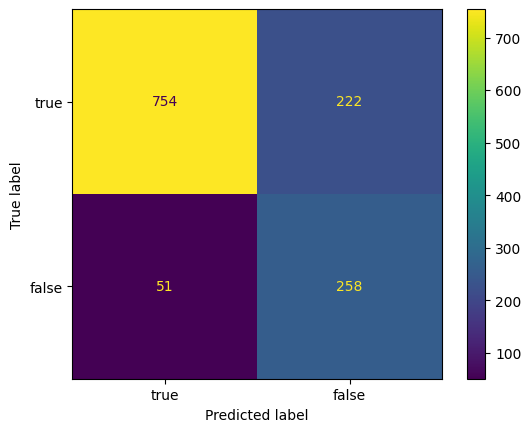

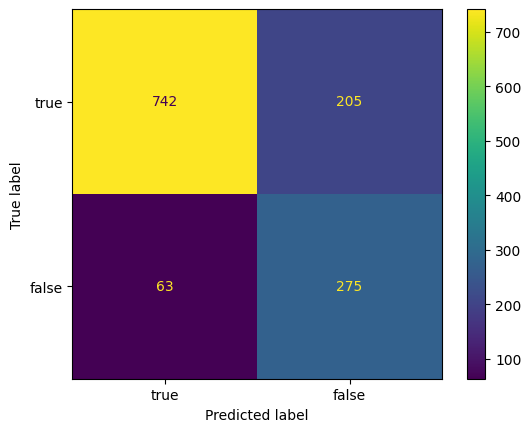

100%|██████████| 1491/1491 [00:08<00:00, 184.09it/s]


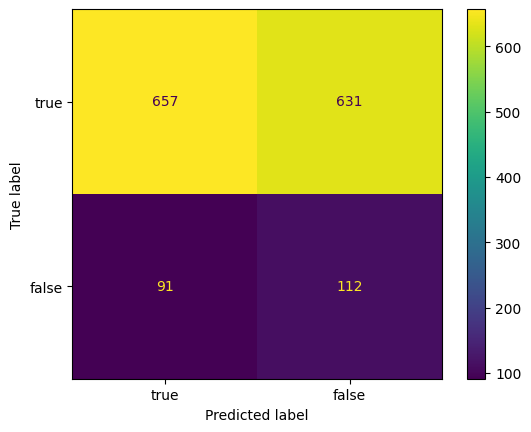

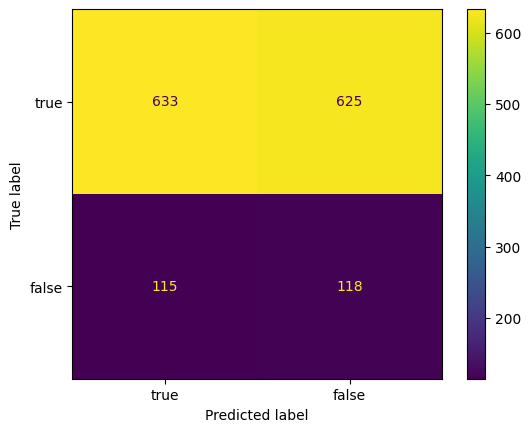

100%|██████████| 817/817 [00:06<00:00, 133.27it/s]


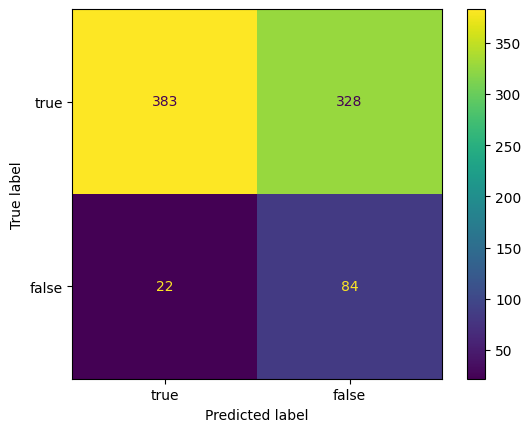

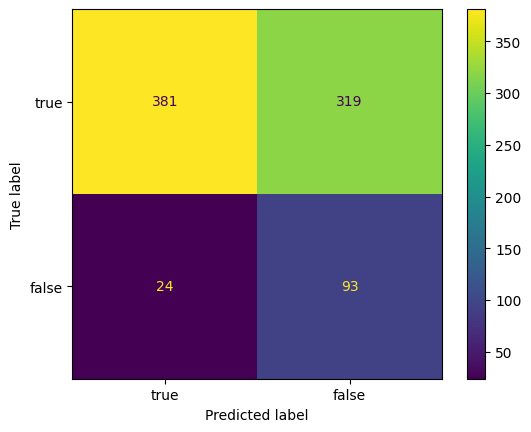

In [140]:
pheme_results_1 = get_results_multi("pheme", 0.2, 50, pheme, [[twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]], model_list)

100%|██████████| 15/15 [00:03<00:00,  3.66s/trial, best loss: 0.4357798165137615]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.77s/trial, best loss: 0.35]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.4285714285714286]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.69s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.34375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:21<00:00, 21.55s/trial, best loss: 0.296875]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Jobs & Education due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.81s/trial, best loss: 0.0]
Skipped category: Business & Industrial due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.70s/trial, best loss: 0.4117647058823529]
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Science due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Internet & Telecom due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Finance due to low numbers


100%|██████████| 1285/1285 [00:13<00:00, 96.69it/s] 


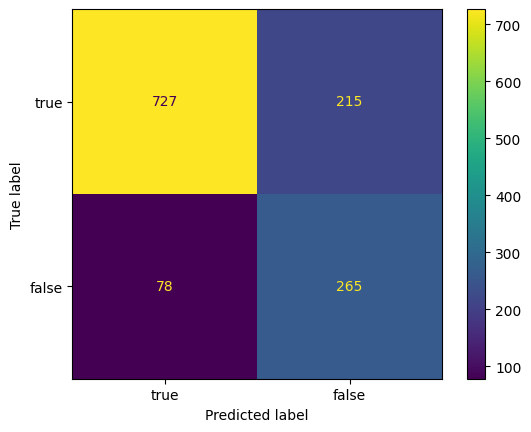

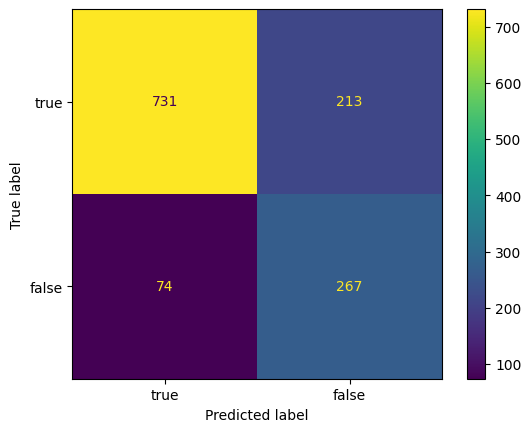

100%|██████████| 1491/1491 [00:19<00:00, 77.79it/s] 


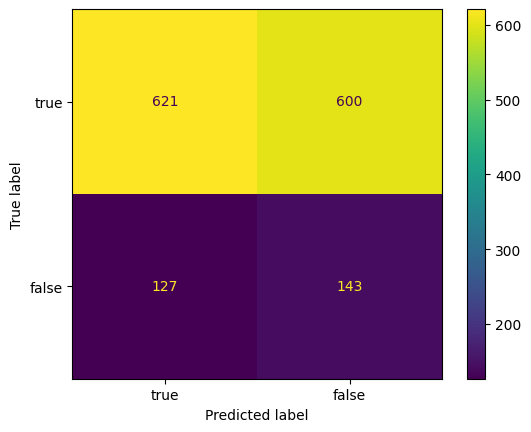

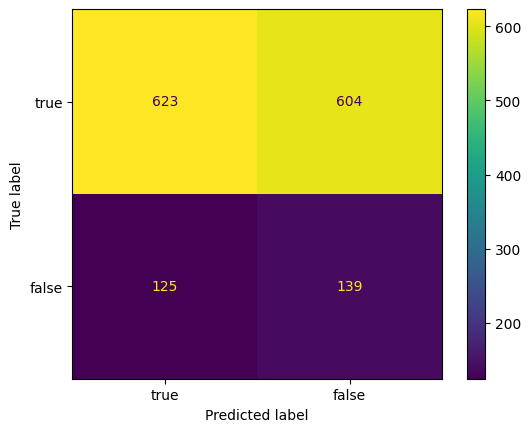

100%|██████████| 817/817 [00:13<00:00, 59.03it/s] 


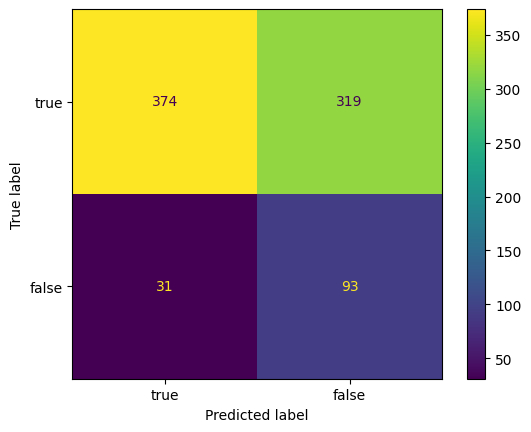

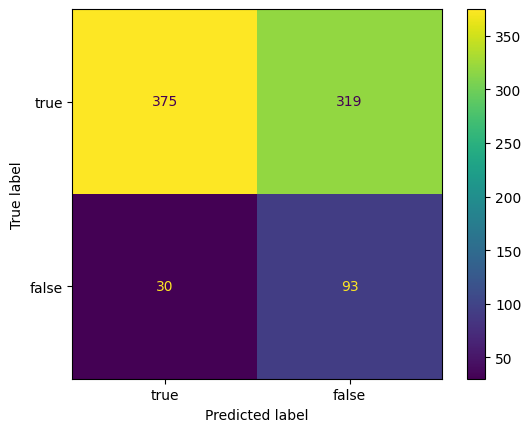

In [141]:
pheme_results_2 = get_results_multi("pheme", 0.5, 20, pheme, [[twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]], model_list)

100%|██████████| 15/15 [00:21<00:00, 21.53s/trial, best loss: 0.40135135135135136]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:21<00:00, 21.51s/trial, best loss=?]
Error training Adaboost in category News, skipping
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:10<00:00, 10.60s/trial, best loss: 0.10389610389610393]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:21<00:00, 21.51s/trial, best loss=?]
Error training Adaboost in category Law & Government, skipping
100%|██████████| 15/15 [00:02<00:00,  2.07s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Health due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.72s/trial, best loss: 0.33333333333333337]
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Science due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Internet & Telecom due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Finance due to low numbers


100%|██████████| 1285/1285 [00:14<00:00, 89.27it/s] 


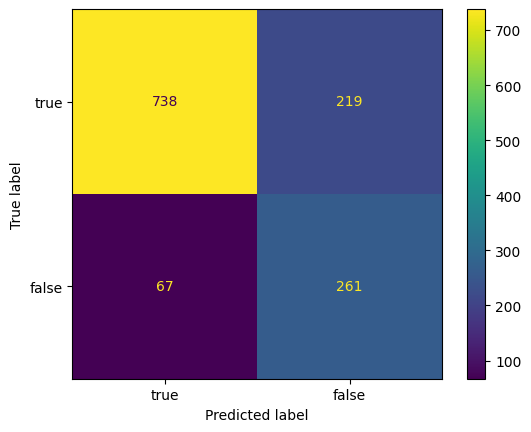

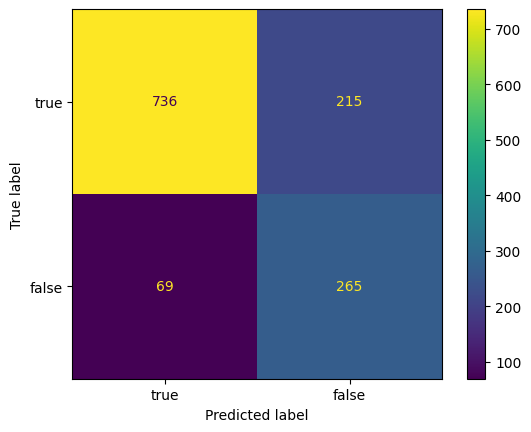

100%|██████████| 1491/1491 [00:14<00:00, 99.57it/s] 


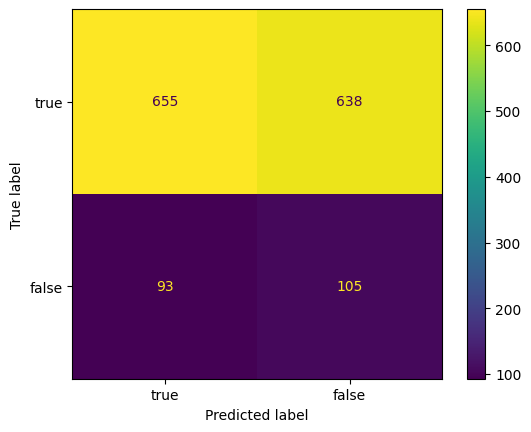

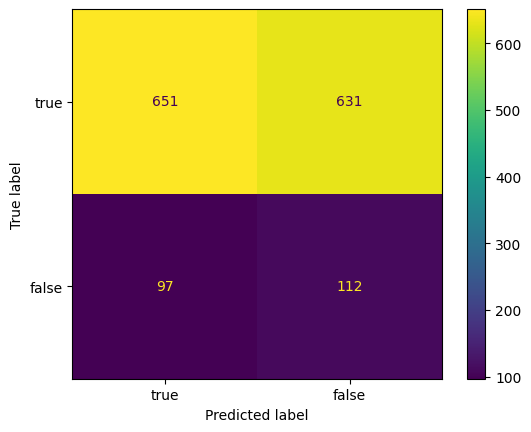

100%|██████████| 817/817 [00:10<00:00, 77.66it/s] 


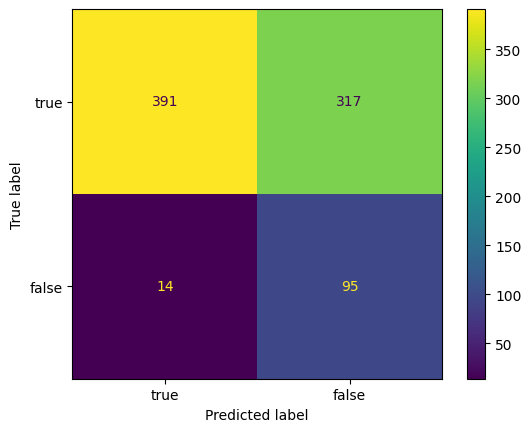

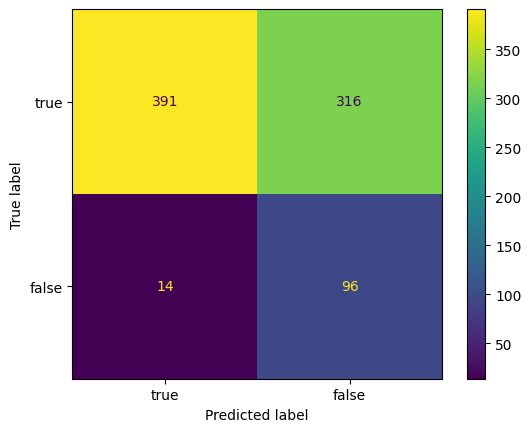

In [142]:
pheme_results_3 = get_results_multi("pheme", 0.2, 200, pheme, [[twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]], model_list)

100%|██████████| 1/1 [00:21<00:00, 21.52s/trial, best loss=?]
Error training Adaboost in category Sensitive Subjects, skipping
100%|██████████| 15/15 [00:10<00:00, 10.24s/trial, best loss: 0.38772455089820357]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.73s/trial, best loss: 0.3650793650793651]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:08<00:00,  8.60s/trial, best loss: 0.38888888888888884]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.57s/trial, best loss: 0.20788530465949817]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:21<00:00, 21.53s/trial, best loss=?]
Error training Adaboost in category Law & Government, skipping
100%|██████████| 15/15 [00:01<00:00,  1.86s/trial, best loss: 0.10191082802547768]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.31s/trial, best loss: 0.11146496815286622]
Skipped category: Books & Literature due to low numbers
100%|██████████| 15/15 [00:02<00:00,  2.13s/trial, best loss: 0.3529411764705882]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.79s/trial, best loss: 0.20588235294117652]
Skipped category: Jobs & Education due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.2777777777777778]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.72s/trial, best loss: 0.6111111111111112]
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Food & Drink due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.37681159420289856]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.86s/trial, best loss: 0.4057971014492754]
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Games due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Science due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Internet & Telecom due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Finance due to low numbers


100%|██████████| 1285/1285 [00:07<00:00, 177.95it/s]


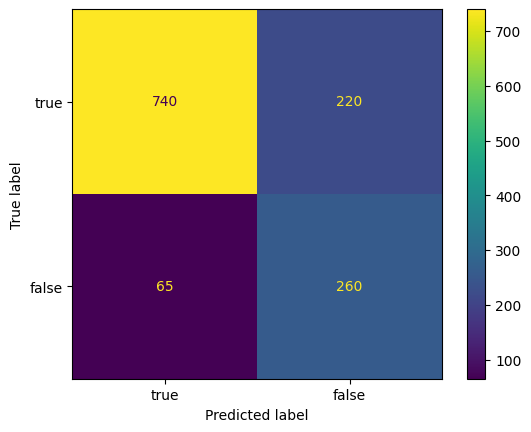

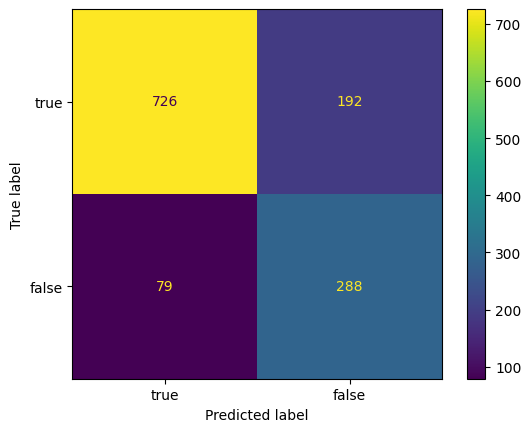

100%|██████████| 1491/1491 [00:10<00:00, 147.59it/s]


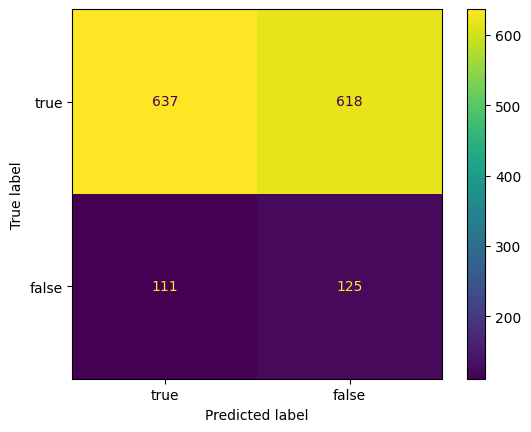

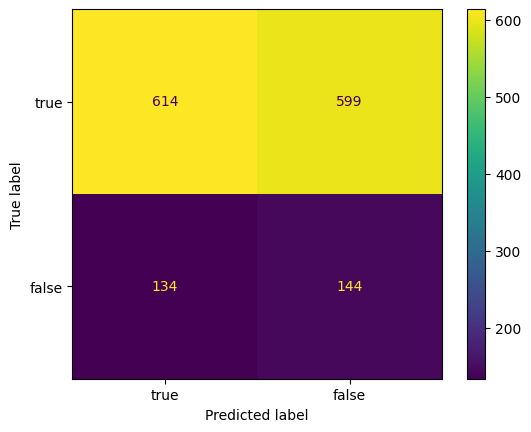

100%|██████████| 817/817 [00:07<00:00, 110.73it/s]


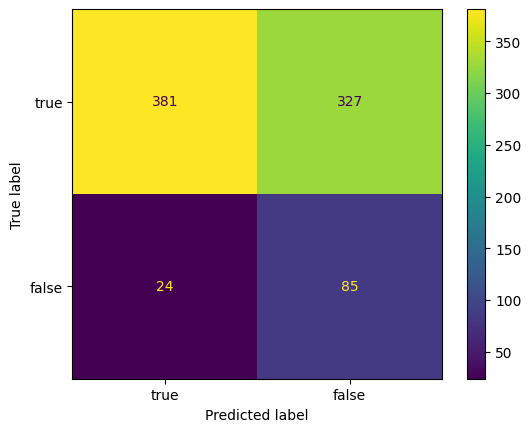

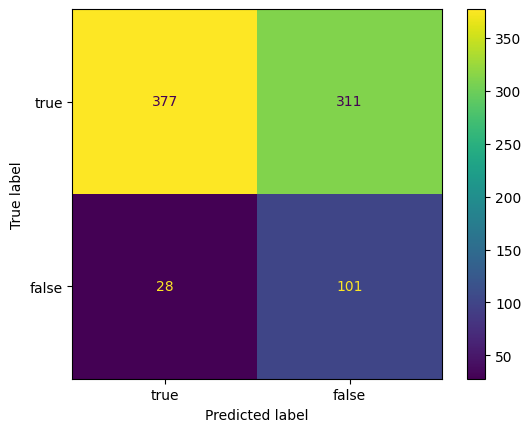

In [143]:
pheme_results_4 = get_results_multi("pheme", 0.0, 100, pheme, [[twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]], model_list)

In [147]:
pheme_results_4

[((77.82, 74.22), (78.91, 76.14)),
 ('twitter15', (51.11, 44.57), (50.84, 45.41)),
 ('twitter16', (57.04, 50.55), (58.51, 53.16))]

In [35]:
test_results = run_tests_multi(tests2, 0.2, 50, model_list)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.18s/trial, best loss: 0.4821428571428571]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.28s/trial, best loss: 0.5694444444444444]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.6111111111111112]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.99s/trial, best loss: 0.3918918918918919]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.19s/trial, best loss: 0.5771812080536913]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.91s/trial, best loss: 0.5625]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.40s/trial, best loss: 0.4838709677419355]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.79s/trial, best loss: 0.47096774193548385]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.96s/trial, best loss: 0.4418604651162791]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.32558139534883723]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.95s/trial, best loss: 0.4651162790697675]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.17647058823529416]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.86s/trial, best loss: 0.375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.95s/trial, best loss: 0.125]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:02<00:00,  2.05s/trial, best loss: 0.4545454545454546]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.4545454545454546]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.96s/trial, best loss: 0.4545454545454546]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.95s/trial, best loss: 0.30000000000000004]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.5384615384615384]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.92s/trial, best loss: 0.3076923076923077]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


 50%|█████     | 1/2 [02:35<02:35, 155.87s/it]

100%|██████████| 1/1 [00:02<00:00,  2.05s/trial, best loss: 0.12068965517241381]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.47s/trial, best loss: 0.12068965517241381]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.36986301369863017]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.28s/trial, best loss: 0.273972602739726]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.92s/trial, best loss: 0.3972602739726028]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:21<00:00, 21.74s/trial, best loss=?]
Error training Adaboost in category News, skipping
100%|██████████| 1/1 [00:01<00:00,  1.85s/trial, best loss: 0.1333333333333333]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.96s/trial, best loss: 0.3246753246753247]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.03s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.51s/trial, best loss: 0.4545454545454546]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.97s/trial, best loss: 0.2727272727272727]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.47058823529411764]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.625]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.90s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.93s/trial, best loss: 0.33333333333333337]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.91s/trial, best loss: 0.4444444444444444]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.2222222222222222]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.93s/trial, best loss: 0.33333333333333337]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.2142857142857143]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.98s/trial, best loss: 0.0714285714285714]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


100%|██████████| 2/2 [06:08<00:00, 184.31s/it]


In [17]:
def train_many_models(tests, confidence_threshold, size_threshold, model_list):
    trained_models = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        trained_models.append((train[2], train_models(train[1], confidence_threshold, size_threshold, train[0], model_list)))
    return trained_models

In [19]:
models_1 = train_many_models(tests, 0.2, 50, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.95s/trial, best loss: 0.5915492957746479]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: 0.5714285714285714]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.96s/trial, best loss: 0.5164835164835164]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.90s/trial, best loss: 0.5824175824175823]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.41s/trial, best loss: 0.5434782608695652]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.94s/trial, best loss: 0.35]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:22<00:00, 22.19s/trial, best loss=?]
Error training Adaboost in category Sensitive Subjects, skipping
100%|██████████| 1/1 [00:02<00:00,  2.08s/trial, best loss: 0.4821428571428571]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.36s/trial, best loss: 0.4285714285714286]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (242) reached and the optimization hasn't converged yet.
  warnings.warn(


Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (242) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.90s/trial, best loss: 0.35]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.82s/trial, best loss: 0.35]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.19999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.93s/trial, best loss: 0.09999999999999998]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:02<00:00,  2.32s/trial, best loss: 0.5333333333333333]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.13s/trial, best loss: 0.5333333333333333]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.5333333333333333]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.25]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.38888888888888884]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.98s/trial, best loss: 0.38888888888888884]

 33%|███▎      | 1/3 [02:41<05:22, 161.26s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.125]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.44999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.36923076923076925]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:21<00:00, 21.80s/trial, best loss=?]
Error training Adaboost in category Law & Government, skipping
100%|██████████| 1/1 [00:02<00:00,  2.30s/trial, best loss: 0.3063063063063063]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.79s/trial, best loss: 0.3063063063063063]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.55s/trial, best loss: 0.2702702702702703]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (151) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (151) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.79s/trial, best loss: 0.15384615384615385]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.04s/trial, best loss: 0.3257575757575758]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.95s/trial, best loss: 0.32432432432432434]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.98s/trial, best loss: 0.18918918918918914]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.2702702702702703]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:02<00:00,  2.11s/trial, best loss: 0.5333333333333333]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.98s/trial, best loss: 0.11111111111111116]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.0]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.5555555555555556]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.86s/trial, best loss: 0.33333333333333337]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.33333333333333337]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.0]

 67%|██████▋   | 2/3 [05:07<02:32, 152.17s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.28125]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.76s/trial, best loss: 0.23076923076923073]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:04<00:00,  4.40s/trial, best loss: 0.23076923076923073]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.31081081081081086]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.2063492063492064]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.35s/trial, best loss: 0.3492063492063492]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: 0.368421052631579]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.27s/trial, best loss: 0.368421052631579]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.89s/trial, best loss: 0.6]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.0]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.82s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers


job exception: The number of classes has to be greater than one; got 1 class

 67%|██████▋   | 2/3 [06:56<02:32, 152.17s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training SVC in category Shopping, skipping


job exception: Expected n_neighbors <= n_samples,  but n_samples = 8, n_neighbors = 10

 67%|██████▋   | 2/3 [06:57<02:32, 152.17s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Shopping, skipping


job exception: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

 67%|██████▋   | 2/3 [06:59<02:32, 152.17s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training Logistic Regression in category Shopping, skipping
100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.83s/trial, best loss: 0.33333333333333337]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.94s/trial, best loss: 0.16666666666666663]

100%|██████████| 3/3 [07:12<00:00, 144.23s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


In [21]:
models_2 = train_many_models(tests, 0.5, 20, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.96s/trial, best loss: 0.7272727272727273]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.91s/trial, best loss: 0.5454545454545454]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: 0.4193548387096774]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.24s/trial, best loss: 0.4516129032258065]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.6111111111111112]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.3584905660377359]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.3076923076923077]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.08s/trial, best loss: 0.5258620689655172]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:05<00:00,  5.09s/trial, best loss: 0.5258620689655172]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.0]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.4444444444444444]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.4285714285714286]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.1428571428571429]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.4]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.76s/trial, best loss: 0.6]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.4]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.3846153846153846]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.3846153846153846]

 33%|███▎      | 1/3 [02:07<04:14, 127.49s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.36363636363636365]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.36363636363636365]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  2.00s/trial, best loss: 0.36363636363636365]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.93s/trial, best loss: 0.1428571428571429]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.90s/trial, best loss: 0.2142857142857143]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (162) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (162) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.25]



c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.25]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.0]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.85s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (180) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.2222222222222222]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.11111111111111116]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.2222222222222222]

 67%|██████▋   | 2/3 [03:58<01:57, 117.84s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.2222222222222222]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.2777777777777778]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.6666666666666667]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.11538461538461542]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.3076923076923077]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.2222222222222222]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.5]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

 67%|██████▋   | 2/3 [04:55<01:57, 117.84s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Online Communities, skipping
100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.5]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.0]
Skipped category: Pets & Animals due to class issues
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 6, n_neighbors = 13

 67%|██████▋   | 2/3 [05:13<01:57, 117.84s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Business & Industrial, skipping
100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to class issues
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers


job exception: The number of classes has to be greater than one; got 1 class

 67%|██████▋   | 2/3 [05:19<01:57, 117.84s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training SVC in category Sports, skipping
100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.19999999999999996]


job exception: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

 67%|██████▋   | 2/3 [05:23<01:57, 117.84s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training Logistic Regression in category Sports, skipping
100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.19999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.19999999999999996]

100%|██████████| 3/3 [05:26<00:00, 108.99s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


In [22]:
models_3 = train_many_models(tests, 0.2, 100, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.6338028169014085]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.5774647887323944]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.17s/trial, best loss: 0.5384615384615384]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.82s/trial, best loss: 0.6153846153846154]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.5597826086956521]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.4836956521739131]
Skipped category: Food & Drink due to low numbers
100%|██████████| 1/1 [00:02<00:00,  2.14s/trial, best loss: 0.5384615384615384]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.91s/trial, best loss: 0.5487179487179488]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.79s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.85s/trial, best loss: 0.5178571428571428]


 33%|███▎      | 1/3 [01:04<02:08, 64.36s/it]

Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate 

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.19999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.52s/trial, best loss: 0.2153846153846154]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.339622641509434]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.97s/trial, best loss: 0.18018018018018023]
Skipped category: Food & Drink due to low numbers
100%|██████████| 1/1 [00:20<00:00, 20.59s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.86s/trial, best loss: 0.2432432432432432]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.44s/trial, best loss: 0.32432432432432434]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.3513513513513513]

 67%|██████▋   | 2/3 [03:18<01:45, 105.44s/it]


Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.74s/trial, best loss: 0.1923076923076923]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: 0.1282051282051282]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.60s/trial, best loss: 0.17948717948717952]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.31081081081081086]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.45945945945945943]
Skipped category: Food & Drink due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.3492063492063492]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.3157894736842105]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.87s/trial, best loss: 0.4736842105263158]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.368421052631579]

100%|██████████| 3/3 [04:17<00:00, 85.99s/it] 


Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate

In [23]:
models_4 = train_many_models(tests, 0, 100, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.15s/trial, best loss: 0.4414414414414415]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.70s/trial, best loss: 0.6126126126126126]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.33s/trial, best loss: 0.5962732919254659]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.6222222222222222]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.83s/trial, best loss: 0.5315985130111525]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.71s/trial, best loss: 0.6022304832713754]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.01s/trial, best loss: 0.4545454545454546]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:15<00:00, 15.87s/trial, best loss: 0.5156950672645739]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.41414141414141414]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.79s/trial, best loss: 0.48484848484848486]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.83s/trial, best loss: 0.4482758620689655]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.67s/trial, best loss: 0.1724137931034483]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.4285714285714286]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.77s/trial, best loss: 0.47619047619047616]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.38095238095238093]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.5238095238095238]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.4285714285714286]


 33%|███▎      | 1/3 [02:58<05:56, 178.35s/it]

Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.3529411764705882]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.33944954128440363]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.02s/trial, best loss: 0.24770642201834858]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.5063291139240507]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.27s/trial, best loss: 0.323170731707317]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.43292682926829273]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.0714285714285714]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.1428571428571429]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:08<00:00,  8.52s/trial, best loss: 0.3422818791946308]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.44s/trial, best loss: 0.25373134328358204]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.4626865671641791]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.67s/trial, best loss: 0.3157894736842105]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.73s/trial, best loss: 0.10526315789473684]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.72s/trial, best loss: 0.0714285714285714]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.69s/trial, best loss: 0.2857142857142857]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.70s/trial, best loss: 0.0714285714285714]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.71s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.99s/trial, best loss: 0.0714285714285714]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.78s/trial, best loss: 0.0]

 67%|██████▋   | 2/3 [05:05<02:28, 148.28s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.81s/trial, best loss: 0.18604651162790697]



c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:15<00:00, 15.86s/trial, best loss: 0.13953488372093026]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.83s/trial, best loss: 0.28846153846153844]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.64s/trial, best loss: 0.3846153846153846]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.64s/trial, best loss: 0.4821428571428571]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.05s/trial, best loss: 0.16190476190476188]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.75s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.61s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.62s/trial, best loss: 0.3918918918918919]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.68s/trial, best loss: 0.2727272727272727]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.10s/trial, best loss: 0.36363636363636365]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.79s/trial, best loss: 0.21212121212121215]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.66s/trial, best loss: 0.4]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.4]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.65s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.66s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 1/1 [00:01<00:00,  1.64s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.66s/trial, best loss: 0.125]

100%|██████████| 3/3 [07:28<00:00, 149.34s/it]


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


In [89]:
ensemble = []
for model in models_1[0][1]['People & Society'].keys():
    set = models_1[0][1]['People & Society']
    ensemble.append((model, set[model]))
clf = VotingClassifier(ensemble, voting="hard")
X_train = np.array([text for text in pheme['e_text']])
clf.fit(X_train, pheme['target'])


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[-0.18634656 -0.03676989  0.15031008 -0.03959699 -0.12490043 -0.07037755
 -0.09134111 -0.04458665  0.1352139  -0.16476609 -0.05009278  0.09190992
 -0.34166586  0.08114699  0.23261669 -0.17008431  0.26703    -0.16768888
 -0.06202133 -0.05942278  0.1092316  -0.02862591  0.05251266 -0.11338406
 -0.05869795  0.33533546 -0.03953567 -0.19303656  0.01340386  0.14430277
  0.12718946 -0.02238544  0.04988867  0.00456388  0.02524789 -0.15779145
 -0.02987773  0.10196378  0.28181955  0.05118968 -0.02515618 -0.03099566
 -0.0779213   0.11291613  0.01456078 -0.17366055  0.015126   -0.2848044
  0.24427599  0.19280988 -0.24432033 -0.08670945  0.14834113 -0.127662
  0.03236877 -0.05287711  0.19145322  0.07521589 -0.19245347 -0.09138723
 -0.07555477  0.27363858 -0.05572034  0.04520389  0.05240389  0.18196422
 -0.18374667  0.18832822  0.18250655 -0.19465455 -0.10638002  0.05715333
  0.2827231   0.084935    0.02958411 -0.09023823  0.21262322  0.03100055
  0.16618191  0.19083691  0.18848822 -0.18259932  0.106947   -0.01263633
 -0.15905377 -0.13997145 -0.05745578 -0.02598044 -0.16546914 -0.22051655
  0.13094386  0.17497684 -0.08850133  0.052844    0.005095    0.15047556
  0.05498667  0.06692345 -0.10702322 -0.14551237 -0.11534366  0.26609001
 -0.20847064 -0.26204512 -0.26585776 -0.2789644   0.07561325  0.1621031
  0.06365511  0.13850023  0.17936866 -0.03577911 -0.04874377  0.16383789
 -0.0411925  -0.02017578 -0.15831366 -0.13642257 -0.05869178  0.08106789
  0.02017177  0.03341779  0.06465533  0.026192   -0.14571334 -0.10601302
 -0.08588845 -0.10384832 -0.32165346  0.43277434  0.22263125 -0.04443278
  0.13772123 -0.02116974 -0.07342443  0.08155388 -0.01546111  0.03273155
 -0.2512722  -0.02160933  0.05281444 -0.16476355  0.01053255  0.18035859
 -0.3449012   0.023987    0.32511413  0.13935401 -0.12777989  0.081007
  0.15717798  0.07340612 -2.21698451 -0.11545645  0.05947145  0.17918311
 -0.10580367  0.17822446  0.02427446 -0.013803    0.13548744  0.10256466
 -0.24156009  0.13866609 -0.01050414 -0.04511344  0.11788198  0.04844212
  0.09757856  0.08501974 -0.24932776  0.13573311  0.11360656  0.02161834
 -0.08702457 -0.11466544 -0.033427    0.01223289 -0.04737334 -0.10691623
 -0.09661411  0.28688347 -0.05942756  0.01578281  0.06951     0.07973965
  0.08174323 -0.18866701 -0.16314334  0.02758878  0.19159548 -0.03379688
 -0.1073091   0.06545316 -0.08683923 -0.040576    0.00380845 -0.19891965
  0.08870278  0.08446962].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [91]:
clf.predict(np.array(twitter['e_text'][0]).reshape(1,-1))

array([False])

In [148]:
weibo = get_dataset("weibo")
weibo = weibo.drop([1933, 3564])

In [151]:
predictions_hard, predictions_soft = predict_points_mutiple_models(models_1[0][1], "weibo_categories.json", weibo)

  0%|          | 0/4662 [00:00<?, ?it/s]

100%|██████████| 4662/4662 [00:27<00:00, 171.96it/s]


In [113]:
from sklearn.svm import SVC
svm = SVC()
X_train = np.array([text for text in ph['e_text']])
svm.fit(X_train, twitter['target'])
X_test = np.array([text for text in weibo['e_text']])
pred = svm.predict(X_test)

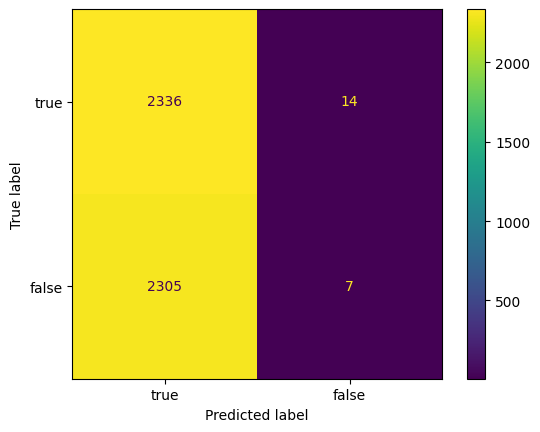

(50.26, 33.71)


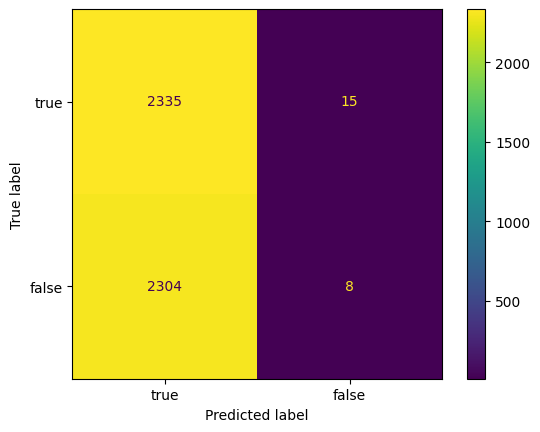

(50.26, 33.75)


In [152]:
print(check_score(weibo['target'], predictions_hard))
print(check_score(weibo['target'], predictions_soft))

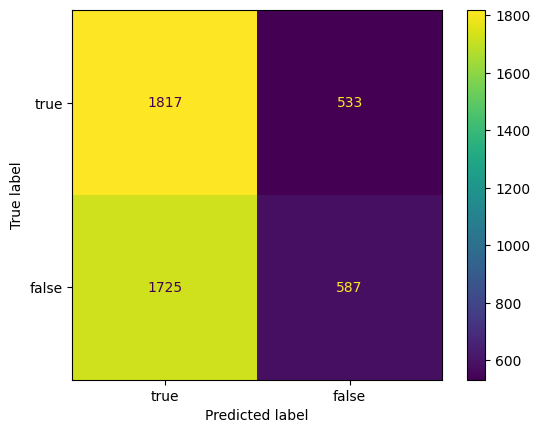

(51.57, 47.94)


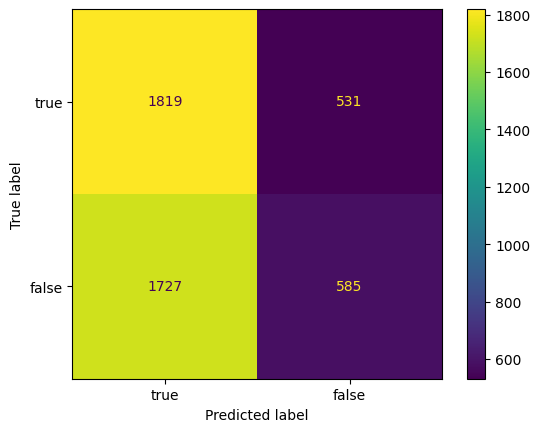

(51.57, 47.92)


In [119]:
print(check_score(weibo["target"], predictions_soft))
print(check_score(weibo["target"], predictions_hard))

In [15]:
tests = [[pheme, "pheme", "PHEME"], [twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"]]
results1 = run_tests(tests, 0.2, 50)
results2 = run_tests(tests, 0.5, 20)
results3 = run_tests(tests, 0.2, 200)
results4 = run_tests(tests, 0, 100)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  2.46s/trial, best loss: 0.3316195372750642]
{'learner': SVC(C=1.27806368437018, coef0=0.48726712591817056, degree=1, gamma='auto',
    kernel='linear', probability=True, random_state=42, shrinking=False,
    tol=0.0006615201746896151), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
100%|██████████| 25/25 [00:05<00:00,  5.37s/trial, best loss: 0.4246913580246914]
{'learner': SVC(C=0.9657655830484548, coef0=0.6786722363807116,
    decision_function_shape='ovo', degree=2, probability=True, random_state=42,
    shrinking=False, tol=1.4737120975701307e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 25/25 [00:01<00:00,  1.97s/trial, best loss: 0.3113207547169812]
{'learner': SVC(C=1.174510237626359, coef0=0.02669401762935497,
    decision_function_shape='ovo', degree=1, gamma='auto', probability=True,
    random_state=42, shrinking=False, tol=0.00929969

 33%|███▎      | 1/3 [12:29<24:58, 749.48s/it]

100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.125]
{'learner': SVC(C=1.1945646294220587, coef0=0.7884022933921573, degree=1, kernel='linear',
    probability=True, random_state=42, tol=0.0005025238209911815), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.24]
{'learner': SVC(C=0.6492912940993498, coef0=0.5441071721230211,
    decision_function_shape='ovo', degree=2, probability=True, random_state=42,
    shrinking=False, tol=6.834361122169257e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.73s/trial, best loss: 0.23809523809523814]
{'learner': SVC(C=0.8382306246268949, coef0=0.1803690144099015, degree=4, probability=True,
    random_state=42, tol=0.0006357388371780233), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Law & Government
100%|██████████| 25/25 [00:01

 67%|██████▋   | 2/3 [24:06<11:58, 718.81s/it]

100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.20833333333333337]
{'learner': SVC(C=1.0739993031808703, coef0=0.416689057344241,
    decision_function_shape='ovo', degree=4, kernel='poly', probability=True,
    random_state=42, shrinking=False, tol=0.0007512366343107693), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.18181818181818177]
{'learner': SVC(C=1.0106129084990836, coef0=0.9259986948470166, degree=2, gamma='auto',
    kernel='linear', probability=True, random_state=42, shrinking=False,
    tol=2.6061167280872727e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.10344827586206895]
{'learner': SVC(C=1.1349840539747738, coef0=0.22540388279634171,
    decision_function_shape='ovo', degree=5, kernel='poly', probability=True,
    random_state=42, tol=8.469028

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00,  1.87s/trial, best loss: 0.4772727272727273]
{'learner': SVC(C=0.9902408249812638, coef0=0.12156199270367096,
    decision_function_shape='ovo', degree=4, gamma='auto', kernel='linear',
    probability=True, random_state=42, tol=0.00045155910532401663), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
100%|██████████| 25/25 [00:01<00:00,  1.58s/trial, best loss: 0.08771929824561409]
{'learner': SVC(C=0.7136085040433904, coef0=0.48747808619366395,
    decision_function_shape='ovo', degree=5, gamma='auto', probability=True,
    random_state=42, tol=0.00011788274422353139), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 25/25 [00:01<00:00,  1.57s/trial, best loss: 0.525]
{'learner': SVC(C=1.3766200869982947, coef0=0.5372880079150215, degree=4, kernel='poly',
    probability=True, random_state=42, tol=0.0009084885622898456), 'preprocs': (), 'ex_preprocs': ()}

 33%|███▎      | 1/3 [09:21<18:42, 561.36s/it]

100%|██████████| 25/25 [00:01<00:00,  1.77s/trial, best loss: 0.3076923076923077]
{'learner': SVC(C=1.0973347350416882, coef0=0.8146959543122512, degree=2, kernel='linear',
    probability=True, random_state=42, shrinking=False,
    tol=0.00020866131622642725), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.94s/trial, best loss: 0.10526315789473684]
{'learner': SVC(C=0.8309466980369555, coef0=0.7462564439354765,
    decision_function_shape='ovo', degree=4, kernel='poly', probability=True,
    random_state=42, tol=0.002540178954143434), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.72s/trial, best loss: 0.25]
{'learner': SVC(C=0.9918299805919085, coef0=0.028751298823087357,
    decision_function_shape='ovo', degree=4, kernel='linear', probability=True,
    random_state=42, tol=0.0001641799004124282), 'preprocs': (), 'ex_preprocs

 67%|██████▋   | 2/3 [20:28<10:23, 623.29s/it]

100%|██████████| 25/25 [00:01<00:00,  1.93s/trial, best loss: 0.2857142857142857]
{'learner': SVC(C=0.7026417007342285, coef0=0.7345482881735375, degree=2, gamma='auto',
    kernel='linear', probability=True, random_state=42,
    tol=0.00875741934024043), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.74s/trial, best loss: 0.2857142857142857]
{'learner': SVC(C=1.1717656596961255, coef0=0.5731214871814254, degree=2, gamma='auto',
    kernel='linear', probability=True, random_state=42,
    tol=0.0006639095964708486), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.76s/trial, best loss: 0.0]
{'learner': SVC(C=0.8644753527772016, coef0=0.25395865614792945,
    decision_function_shape='ovo', degree=1, probability=True, random_state=42,
    shrinking=False, tol=0.00817403429570748), 'preprocs': (), 'ex_preprocs': ()}
Created SVM traine

job exception: The number of classes has to be greater than one; got 1 class

 67%|██████▋   | 2/3 [29:39<10:23, 623.29s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
error training Sports svm, skipping
Skipped category: Sensitive Subjects/Firearms & Weapons due to low numbers
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Sensitive Subjects/Recreational Drugs due to low numbers
Skipped category: Real Estate due to low numbers


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  2.54s/trial, best loss: 0.3256410256410256]
{'learner': SVC(C=1.4850977719052936, coef0=0.7213847427709724,
    decision_function_shape='ovo', degree=4, gamma='auto', kernel='linear',
    probability=True, random_state=42, shrinking=False,
    tol=0.0003521601209020623), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
100%|██████████| 25/25 [00:02<00:00,  2.50s/trial, best loss: 0.4156479217603912]
{'learner': SVC(C=1.1200050163118433, coef0=0.994496830106449, degree=5, gamma='auto',
    kernel='poly', probability=True, random_state=42, shrinking=False,
    tol=0.0010135904438530305), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 25/25 [00:02<00:00,  2.39s/trial, best loss: 0.27314814814814814]
{'learner': SVC(C=1.1708437379896266, coef0=0.485690543308848, gamma='auto',
    probability=True, random_state=42, shrinking=False,
    tol=0.00011814792103229

 33%|███▎      | 1/3 [09:39<19:19, 579.68s/it]

100%|██████████| 25/25 [00:01<00:00,  1.64s/trial, best loss: 0.12121212121212122]
{'learner': SVC(C=1.053170110418928, coef0=0.5772521344971144, degree=4, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=0.0015240630301997062), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.65s/trial, best loss: 0.28846153846153844]
{'learner': SVC(C=1.5143011307215515, coef0=0.9028860174159863,
    decision_function_shape='ovo', degree=5, gamma='auto', kernel='poly',
    probability=True, random_state=42, tol=0.003082161441447713), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.65s/trial, best loss: 0.33333333333333337]
{'learner': SVC(C=1.076290480716731, coef0=0.8842217989495117,
    decision_function_shape='ovo', degree=2, probability=True, random_state=42,
    tol=6.965222376786167e-05), 'preprocs': (), 'ex_pr

 67%|██████▋   | 2/3 [15:57<07:40, 460.84s/it]

100%|██████████| 25/25 [00:01<00:00,  1.67s/trial, best loss: 0.16000000000000003]
{'learner': SVC(C=1.0150034429945505, coef0=0.4277436151638021, degree=4, probability=True,
    random_state=42, tol=5.697602835540444e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.64s/trial, best loss: 0.2272727272727273]
{'learner': SVC(C=0.6883588002316052, coef0=0.530058644489191,
    decision_function_shape='ovo', degree=4, kernel='poly', probability=True,
    random_state=42, tol=3.202134316824303e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.64s/trial, best loss: 0.09677419354838712]
{'learner': SVC(C=1.3086733391297063, coef0=0.1611692395882237,
    decision_function_shape='ovo', degree=4, kernel='poly', probability=True,
    random_state=42, shrinking=False, tol=0.00011394522825153981), 'preprocs': (), 'ex_preprocs': ()}
Cre

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  2.44s/trial, best loss: 0.26615969581749055]
{'learner': SVC(C=1.0354579939043367, coef0=0.6343214579891316, degree=1, kernel='poly',
    probability=True, random_state=42, tol=0.005462888691007148), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Sensitive Subjects/War & Conflict
100%|██████████| 25/25 [00:03<00:00,  3.26s/trial, best loss: 0.43202416918429]
{'learner': SVC(C=0.8188298309947025, coef0=0.9174219843469561, degree=2, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=8.668548470353182e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: News
100%|██████████| 25/25 [00:02<00:00,  2.39s/trial, best loss: 0.36923076923076925]
{'learner': SVC(C=0.6413929204561002, coef0=0.14483087242897996, degree=2, gamma='auto',
    kernel='linear', probability=True, random_state=42, shrinking=False,
    tol=0.0021260473311007105), 'preprocs': (), 'ex_preprocs': ()}
Created SVM traine

 33%|███▎      | 1/3 [13:41<27:23, 821.74s/it]

100%|██████████| 25/25 [00:01<00:00,  1.79s/trial, best loss: 0.1785714285714286]
{'learner': SVC(C=0.9689573367316257, coef0=0.4308797345901485,
    decision_function_shape='ovo', gamma='auto', kernel='linear',
    probability=True, random_state=42, tol=2.3634845999761477e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.78s/trial, best loss: 0.23529411764705888]
{'learner': SVC(C=0.708658334469585, coef0=0.4802867330432232,
    decision_function_shape='ovo', degree=4, probability=True, random_state=42,
    shrinking=False, tol=2.3984789710312818e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.75s/trial, best loss: 0.19999999999999996]
{'learner': SVC(C=1.1842439006344645, coef0=0.9222532817907875,
    decision_function_shape='ovo', degree=4, gamma='auto', kernel='linear',
    probability=True, random_state=42, tol=0.00

 67%|██████▋   | 2/3 [23:59<11:41, 701.71s/it]

100%|██████████| 25/25 [00:01<00:00,  1.63s/trial, best loss: 0.18918918918918914]
{'learner': SVC(C=1.1854487404071743, coef0=0.4616991803791799, degree=5, kernel='poly',
    probability=True, random_state=42, tol=0.006744868923094926), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: People & Society
100%|██████████| 25/25 [00:01<00:00,  1.64s/trial, best loss: 0.18604651162790697]
{'learner': SVC(C=0.8238837122820875, coef0=0.29430990881146823, degree=5, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=0.00015236716068676753), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trained in category: Arts & Entertainment
100%|██████████| 25/25 [00:01<00:00,  1.65s/trial, best loss: 0.09090909090909094]
{'learner': SVC(C=1.0288633092207546, coef0=0.6241710851772245,
    decision_function_shape='ovo', degree=4, kernel='poly', probability=True,
    random_state=42, tol=1.7548258743746086e-05), 'preprocs': (), 'ex_preprocs': ()}
Created SVM trai

100%|██████████| 3/3 [33:56<00:00, 678.73s/it]


In [14]:
X_train, X_val, y_train, y_val = train_test_split(pheme.drop("target", axis=1), pheme["target"], train_size=0.8, stratify=pheme["target"]) 
train_set = pd.concat([X_train, y_train], axis=1)
models = train_models("pheme", 0.2, 50, train_set, model_list)
a = predict_points_mutiple_models(models, "pheme_categories.json", X_val)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.13s/trial, best loss: 0.6338028169014085]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:06<00:00,  6.33s/trial, best loss: 0.5694444444444444]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.88s/trial, best loss: 0.5759493670886076]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.98s/trial, best loss: 0.5555555555555556]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.84s/trial, best loss: 0.5111111111111111]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.82s/trial, best loss: 0.375]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.76s/trial, best loss: 0.375]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.80s/trial, best loss: 0.5833333333333333]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.82s/trial, best loss: 0.33333333333333337]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:01<00:00,  1.93s/trial, best loss: 0.23076923076923073]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


100%|██████████| 1285/1285 [00:09<00:00, 131.00it/s]


In [16]:
multi_result1 = get_tests_multi(tests, 0.2, 50, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.36s/trial, best loss: 0.6]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training Adaboost in category People & Society, skipping
100%|██████████| 1/1 [00:02<00:00,  2.06s/trial, best loss: 0.5945945945945945]


In [ ]:
multi_result2 = run_tests_multi(tests, 0.5, 20, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  1.72s/trial, best loss: 0.6]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.80s/trial, best loss: 0.36]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.71s/trial, best loss: 0.45833333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.70s/trial, best loss: 0.20833333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.19999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.69s/trial, best loss: 0.6046511627906976]



c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.69s/trial, best loss: 0.41860465116279066]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.09999999999999998]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.91s/trial, best loss: 0.34782608695652173]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.58s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.62s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (307) reached and the optimization hasn't converged yet.
  warnings.warn(


Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (307) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.61s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.61s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.0]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.62s/trial, best loss: 0.6]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.4]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.61s/trial, best loss: 0.4]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.69s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.30000000000000004]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.30000000000000004]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


 33%|███▎      | 1/3 [26:10<52:21, 1570.65s/it]

100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.33333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.58s/trial, best loss: 0.2777777777777778]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.62s/trial, best loss: 0.1428571428571429]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.71s/trial, best loss: 0.18181818181818177]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.90s/trial, best loss: 0.13636363636363635]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.265625]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 13/13 [00:01<00:00,  1.85s/trial, best loss: 0.25]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 12, n_neighbors = 14

 33%|███▎      | 1/3 [40:13<52:21, 1570.65s/it]

 93%|█████████▎| 13/14 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Online Communities, skipping
100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.41s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.51s/trial, best loss: 0.0]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  2.00s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.11s/trial, best loss: 0.0]
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.81s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 8, n_neighbors = 11

 33%|███▎      | 1/3 [46:42<52:21, 1570.65s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Business & Industrial, skipping
100%|██████████| 15/15 [00:01<00:00,  1.96s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.87s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
100%|██████████| 4/4 [00:02<00:00,  2.00s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 12, n_neighbors = 14

 33%|███▎      | 1/3 [48:39<52:21, 1570.65s/it]

 80%|████████  | 4/5 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Shopping, skipping
100%|██████████| 15/15 [00:01<00:00,  1.79s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.03s/trial, best loss: 0.0]
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 15/15 [00:02<00:00,  2.31s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.74s/trial, best loss: 0.25]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


 67%|██████▋   | 2/3 [52:44<26:24, 1584.46s/it]

100%|██████████| 15/15 [00:01<00:00,  1.80s/trial, best loss: 0.2142857142857143]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.84s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.98s/trial, best loss: 0.10526315789473684]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.12s/trial, best loss: 0.1578947368421053]
Skipped category: Food & Drink due to class issues
100%|██████████| 15/15 [00:02<00:00,  2.64s/trial, best loss: 0.03448275862068961]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.91s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 5

 67%|██████▋   | 2/3 [1:05:03<26:24, 1584.46s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Online Communities, skipping
100%|██████████| 15/15 [00:02<00:00,  2.23s/trial, best loss: 0.5]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.10s/trial, best loss: 0.0]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 2/2 [00:01<00:00,  2.00s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 8

 67%|██████▋   | 2/3 [1:07:01<26:24, 1584.46s/it]

 67%|██████▋   | 2/3 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Health, skipping
100%|██████████| 15/15 [00:01<00:00,  1.78s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.93s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.0]
Skipped category: Pets & Animals due to class issues
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.74s/trial, best loss: 0.0]


job exception: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 9

 67%|██████▋   | 2/3 [1:08:52<26:24, 1584.46s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training KNN in category Business & Industrial, skipping
100%|██████████| 15/15 [00:01<00:00,  1.91s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.78s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.01s/trial, best loss: 0.0]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to class issues
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers


job exception: The number of classes has to be greater than one; got 1 class

 67%|██████▋   | 2/3 [1:10:18<26:24, 1584.46s/it]

  0%|          | 0/1 [00:02<?, ?trial/s, best loss=?]
Error training SVC in category Sports, skipping
100%|██████████| 15/15 [00:01<00:00,  1.98s/trial, best loss: 0.25]


job exception: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

 67%|██████▋   | 2/3 [1:10:49<26:24, 1584.46s/it]

  0%|          | 0/1 [00:01<?, ?trial/s, best loss=?]
Error training Logistic Regression in category Sports, skipping
100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.25]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


100%|██████████| 3/3 [1:13:21<00:00, 1467.02s/it]


[('PHEME',
  [((64.9, 47.49), (64.82, 47.44)),
   ('twitter15', (52.05, 39.26), (51.78, 38.83)),
   ('twitter16', (50.8, 36.75), (51.04, 37.25))]),
 ('twitter15',
  [((62.88, 61.21), (63.55, 61.79)),
   ('PHEME', (61.4, 51.65), (61.37, 51.53)),
   ('twitter16', (53.0, 46.59), (53.0, 46.38))]),
 ('twitter16',
  [((69.51, 67.58), (69.51, 67.58)),
   ('PHEME', (62.05, 60.04), (61.68, 59.74)),
   ('twitter15', (51.37, 46.11), (51.31, 46.21))])]

In [ ]:
multi_result3 = run_tests_multi(tests, 0.2, 200, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:07<00:00,  7.32s/trial, best loss: 0.45614035087719296]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.87s/trial, best loss: 0.3918918918918919]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.45070422535211263]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.75s/trial, best loss: 0.47619047619047616]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:08<00:00,  8.50s/trial, best loss: 0.5714285714285714]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.76s/trial, best loss: 0.44897959183673475]
Skipped category: Food & Drink due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.89s/trial, best loss: 0.48026315789473684]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.05s/trial, best loss: 0.4078947368421053]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.43181818181818177]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.96s/trial, best loss: 0.34090909090909094]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.36363636363636365]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low number

 33%|███▎      | 1/3 [18:31<37:03, 1111.68s/it]

100%|██████████| 15/15 [00:01<00:00,  1.92s/trial, best loss: 0.24242424242424243]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.89s/trial, best loss: 0.26415094339622647]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:03<00:00,  3.29s/trial, best loss: 0.2558139534883721]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.97s/trial, best loss: 0.23863636363636365]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.11s/trial, best loss: 0.20454545454545459]
Skipped category: Food & Drink due to low numbers
100%|██████████| 15/15 [00:02<00:00,  2.36s/trial, best loss: 0.21904761904761905]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.38s/trial, best loss: 0.23809523809523814]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.23s/trial, best loss: 0.19354838709677424]



c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.85s/trial, best loss: 0.22580645161290325]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low number

 67%|██████▋   | 2/3 [40:26<20:31, 1231.45s/it]

100%|██████████| 15/15 [00:02<00:00,  2.25s/trial, best loss: 0.23076923076923073]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.36s/trial, best loss: 0.1923076923076923]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.22s/trial, best loss: 0.09999999999999998]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.19s/trial, best loss: 0.050000000000000044]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.28s/trial, best loss: 0.19999999999999996]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.28s/trial, best loss: 0.12068965517241381]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.17s/trial, best loss: 0.051724137931034475]
Skipped category: Food & Drink due to low numbers
100%|██████████| 15/15 [00:02<00:00,  2.19s/trial, best loss: 0.27450980392156865]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.16s/trial, best loss: 0.2666666666666667]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.37s/trial, best loss: 0.2666666666666667]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.24s/trial, best loss: 0.06666666666666665]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
Skipped category: Health due to low numbers
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
Skipped category: Business & Industrial due to low numbers
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
Skipped category: Sports due to low numbers
Skipped category: Games due to low number

100%|██████████| 3/3 [1:00:53<00:00, 1217.67s/it]


[('PHEME',
  [((66.93, 56.46), (66.69, 56.28)),
   ('twitter15', (51.51, 41.61), (51.17, 41.16)),
   ('twitter16', (52.26, 41.46), (52.51, 41.91))]),
 ('twitter15',
  [((63.88, 61.02), (63.88, 60.86)),
   ('PHEME', (61.56, 52.93), (61.67, 52.94)),
   ('twitter16', (56.18, 49.09), (56.06, 48.89))]),
 ('twitter16',
  [((71.34, 69.8), (71.34, 69.8)),
   ('PHEME', (61.54, 60.14), (61.51, 60.11)),
   ('twitter15', (52.78, 48.61), (53.12, 48.78))])]

In [ ]:
multi_result4 = run_tests_multi(tests, 0, 100, model_list)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  2.28s/trial, best loss: 0.5168539325842696]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:14<00:00, 14.02s/trial, best loss: 0.5056179775280899]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.17s/trial, best loss: 0.3700787401574803]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:13<00:00, 13.68s/trial, best loss: 0.4803149606299213]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.96s/trial, best loss: 0.41509433962264153]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.24s/trial, best loss: 0.4339622641509434]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:03<00:00,  3.30s/trial, best loss: 0.519047619047619]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.2941176470588235]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.86s/trial, best loss: 0.4285714285714286]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.30s/trial, best loss: 0.43999999999999995]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.79s/trial, best loss: 0.22784810126582278]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.31645569620253167]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.96s/trial, best loss: 0.189873417721519]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.17391304347826086]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.71s/trial, best loss: 0.08695652173913049]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.11764705882352944]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.2941176470588235]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.2941176470588235]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.62s/trial, best loss: 0.4117647058823529]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


 33%|███▎      | 1/3 [32:18<1:04:36, 1938.40s/it]

100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.1428571428571429]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:04<00:00,  4.73s/trial, best loss: 0.2142857142857143]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.22093023255813948]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.17741935483870963]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.27419354838709675]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.3007518796992481]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.09090909090909094]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.2542372881355932]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.2545454545454545]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.72s/trial, best loss: 0.2545454545454545]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:02<00:00,  2.40s/trial, best loss: 0.18181818181818177]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.125]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.08333333333333337]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.08333333333333337]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.09090909090909094]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.62s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (276) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (276) reached and the optimization hasn't converged yet.
  warnings.warn(


Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


 67%|██████▋   | 2/3 [1:00:25<29:50, 1790.81s/it]

100%|██████████| 15/15 [00:06<00:00,  6.85s/trial, best loss: 0.23529411764705888]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.91s/trial, best loss: 0.2093023255813954]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.76s/trial, best loss: 0.0444444444444444]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.64s/trial, best loss: 0.11111111111111116]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.16470588235294115]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.95s/trial, best loss: 0.23333333333333328]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.63s/trial, best loss: 0.28]



c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.68s/trial, best loss: 0.16000000000000003]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.65s/trial, best loss: 0.19999999999999996]
Skipped category: Internet & Telecom due to low numbers
Skipped category: Computers & Electronics due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.25]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.67s/trial, best loss: 0.375]
Skipped category: Pets & Animals due to low numbers
Skipped category: Reference due to low numbers
Skipped category: Adult due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.60s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.59s/trial, best loss: 0.0]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.66s/trial, best loss: 0.16666666666666663]
Skipped category: Books & Literature due to low numbers
Skipped category: Jobs & Education due to low numbers
Skipped category: Shopping due to low numbers
Skipped category: Beauty & Fitness due to low numbers
Skipped category: Autos & Vehicles due to low numbers
Skipped category: Science due to low numbers
Skipped category: Finance due to low numbers
Skipped category: Travel & Transportation due to low numbers
Skipped category: Hobbies & Leisure due to low numbers
100%|██████████| 15/15 [00:01<00:00,  1.72s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.58s/trial, best loss: 0.16666666666666663]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 15/15 [00:01<00:00,  1.71s/trial, best loss: 0.16666666666666663]
Skipped category: Games due to low numbers
Skipped category: Home & Garden due to low numbers
Skipped category: Real Estate due to low numbers


100%|██████████| 3/3 [1:24:28<00:00, 1689.43s/it]


[('PHEME',
  [((67.47, 60.83), (67.63, 61.02)),
   ('twitter15', (51.17, 43.71), (51.64, 44.4)),
   ('twitter16', (54.71, 47.38), (55.08, 47.75))]),
 ('twitter15',
  [((66.89, 64.47), (66.89, 64.47)),
   ('PHEME', (61.56, 52.72), (61.46, 52.56)),
   ('twitter16', (55.45, 49.17), (55.69, 49.45))]),
 ('twitter16',
  [((68.9, 67.23), (68.9, 67.23)),
   ('PHEME', (60.23, 58.71), (60.3, 58.82)),
   ('twitter15', (53.79, 50.01), (53.52, 49.6))])]

In [1]:
multi_result1

NameError: name 'multi_result1' is not defined

In [31]:
a = predict_points_mutiple_models(models, "pheme_categories.json", X_val)
check_score(a, y_val)

  0%|          | 0/1285 [00:00<?, ?it/s]

100%|██████████| 1285/1285 [00:36<00:00, 34.93it/s]


(80.54, 77.7)

In [120]:
tests = [[pheme, "pheme", "PHEME"], [twitter15, "twitter", "twitter15"], [twitter16, "twitter", "twitter16"], [weibo, "weibo", "weibo"]]
#r = get_results_multi("pheme", 0.2, 50, pheme, tests, model_list)

In [121]:
# Multi baseline
from sklearn.ensemble import VotingClassifier

def evaluate_baseline(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    f1_mod = f1_score(y_test, pred_y, average="macro")
    return float("{0:.2f}".format(acc_mod*100)), float("{0:.2f}".format(f1_mod*100))


def run_baseline_tests(tests, model_list):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_baseline_results(train[0], tests, model_list)))
    return test_results

def get_baseline_results(train, tests, model_list): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    X_train_text = np.array([text for text in X_train['e_text']])
    X_val_text = np.array([text for text in X_val['e_text']])
    models = []
    for model_name, model in model_list:
        baseline_model = optimize_model(model, X_train_text, y_train)
        sk_model = baseline_model.best_model()["learner"].fit(X_train_text, y_train)
        models.append((model_name, sk_model))

    vc_hard = VotingClassifier(estimators=models, voting="hard")
    vc_hard = vc_hard.fit(X_train_text, y_train)
    vc_soft = VotingClassifier(estimators=models, voting="soft")
    vc_soft.fit(X_train_text, y_train)

    results = []
    results.append((evaluate_baseline(vc_hard, X_val_text, y_val), evaluate_baseline(vc_soft, X_val_text, y_val)))
    for test_set, test_cat, test_name in tests:
        test_data = test_set.drop("target", axis=1)
        test_data_text = np.array([text for text in test_data['e_text']])
        test_target = test_set["target"]
        results.append((test_name, evaluate_baseline(vc_hard, test_data_text, test_target), evaluate_baseline(vc_soft, test_data_text, test_target),))
    return results

multi_baseline_results = run_baseline_tests(tests, model_list)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.63s/trial, best loss: 0.21400778210116733]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.17s/trial, best loss: 0.24708171206225682]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:03<00:00,  3.96s/trial, best loss: 0.21108949416342415]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 25%|██▌       | 1/4 [01:11<03:33, 71.00s/it]

100%|██████████| 1/1 [00:02<00:00,  2.18s/trial, best loss: 0.3138075313807531]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.35s/trial, best loss: 0.20920502092050208]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 50%|█████     | 2/4 [01:32<01:24, 42.03s/it]

100%|██████████| 1/1 [00:01<00:00,  1.85s/trial, best loss: 0.2137404580152672]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.05s/trial, best loss: 0.2137404580152672]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
 75%|███████▌  | 3/4 [02:12<00:40, 40.98s/it]

100%|██████████| 1/1 [00:16<00:00, 16.19s/trial, best loss: 0.37131367292225204]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 1/1 [00:02<00:00,  2.69s/trial, best loss: 0.3552278820375335]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
100%|██████████| 4/4 [04:56<00:00, 74.23s/it]


In [122]:
multi_baseline_results

[('PHEME',
  [((77.74, 74.39), (79.61, 77.6)),
   ('PHEME', (85.45, 83.52), (93.29, 92.75)),
   ('twitter15', (52.11, 46.02), (50.44, 46.21)),
   ('twitter16', (61.44, 57.53), (63.4, 60.97)),
   ('weibo', (50.47, 33.66), (50.77, 34.62))]),
 ('twitter15',
  [((80.27, 80.25), (79.26, 79.26)),
   ('PHEME', (60.09, 53.85), (58.26, 53.35)),
   ('twitter15', (91.55, 91.54), (95.84, 95.84)),
   ('twitter16', (58.26, 54.93), (60.47, 58.1)),
   ('weibo', (45.71, 44.75), (46.59, 45.74))]),
 ('twitter16',
  [((74.39, 74.29), (76.22, 76.15)),
   ('PHEME', (54.27, 54.19), (53.32, 53.22)),
   ('twitter15', (57.14, 57.03), (59.29, 59.1)),
   ('twitter16', (91.06, 91.05), (94.61, 94.61)),
   ('weibo', (49.44, 35.64), (46.83, 44.05))]),
 ('weibo',
  [((65.27, 65.27), (63.24, 62.92)),
   ('PHEME', (59.84, 43.72), (60.81, 41.54)),
   ('twitter15', (49.56, 38.81), (49.36, 36.26)),
   ('twitter16', (48.84, 38.2), (47.98, 34.56)),
   ('weibo', (68.38, 68.38), (71.69, 71.51))])]

In [12]:
def evaluate_baseline(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    f1_mod = f1_score(y_test, pred_y, average="macro")
    return float("{0:.2f}".format(acc_mod*100)), float("{0:.2f}".format(f1_mod*100))


def run_baseline_tests(tests):
    test_results = []
    for i in tqdm(range(len(tests))):
        t = tests.copy()
        train = t.pop(i)
        test_results.append((train[2], get_baseline_results(train[0], tests)))
    return test_results

def get_baseline_results(train, tests): 
    X_train, X_val, y_train, y_val = train_test_split(train.drop("target", axis=1), train["target"], train_size=0.8, stratify=train["target"]) 
    X_train_text = np.array([text for text in X_train['e_text']])
    X_val_text = np.array([text for text in X_val['e_text']])
    baseline = optimize_model("svm", X_train_text, y_train)
    results = []
    results.append(evaluate_baseline(baseline, X_val_text, y_val))
    for test_set, test_cat, test_name in tests:
        test_data = test_set.drop("target", axis=1)
        test_data_text = np.array([text for text in test_data['e_text']])
        test_target = test_set["target"]
        results.append((test_name, evaluate_baseline(baseline, test_data_text, test_target)))
    return results

baseline_results = run_baseline_tests(tests)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:06<00:00,  6.66s/trial, best loss: 0.15369649805447472]
{'learner': SVC(C=1.2007340688965829, coef0=0.41195154588714744, degree=5, kernel='poly',
    probability=True, random_state=42, tol=0.0021174726338347707), 'preprocs': (), 'ex_preprocs': ()}


 33%|███▎      | 1/3 [03:05<06:11, 185.73s/it]

100%|██████████| 25/25 [00:01<00:00,  1.97s/trial, best loss: 0.20502092050209209]
{'learner': SVC(C=0.5853585639125682, coef0=0.9129795392049047,
    decision_function_shape='ovo', degree=5, kernel='poly', probability=True,
    random_state=42, tol=2.2560165272510383e-05), 'preprocs': (), 'ex_preprocs': ()}


 67%|██████▋   | 2/3 [03:59<01:48, 108.03s/it]

100%|██████████| 25/25 [00:01<00:00,  1.88s/trial, best loss: 0.1984732824427481]
{'learner': SVC(C=0.9906379338992914, coef0=0.5764761568576748, degree=2, kernel='poly',
    probability=True, random_state=42, shrinking=False,
    tol=8.617804258277811e-05), 'preprocs': (), 'ex_preprocs': ()}


100%|██████████| 3/3 [04:46<00:00, 95.48s/it] 


In [13]:
baseline_results

[('PHEME',
  [(83.5, 82.24),
   ('PHEME', (94.09, 93.64)),
   ('twitter15', (50.17, 47.63)),
   ('twitter16', (61.69, 59.78))]),
 ('twitter15',
  [(81.61, 81.6),
   ('PHEME', (55.7, 51.97)),
   ('twitter15', (95.91, 95.91)),
   ('twitter16', (62.3, 60.07))]),
 ('twitter16',
  [(74.39, 74.39),
   ('PHEME', (61.29, 60.87)),
   ('twitter15', (56.2, 55.43)),
   ('twitter16', (87.52, 87.52))])]

In [153]:
from google.cloud import language_v2

def split_labels(categories):
    """The category labels are of the form "/a/b/c" up to three levels,
    for example "/Computers & Electronics/Software", and these labels
    are used as keys in the categories dictionary, whose values are
    confidence scores.

    The split_labels function splits the keys into individual levels
    while duplicating the confidence score, which allows a natural
    boost in how we calculate similarity when more levels are in common.

    Example:
    If we have

    x = {"/a/b/c": 0.5}
    y = {"/a/b": 0.5}
    z = {"/a": 0.5}

    Then x and y are considered more similar than y and z.
    """
    _categories = {}
    for name, confidence in categories.items():
        labels = [label for label in name.split("/") if label]
        for label in labels:
            _categories[label] = confidence

    return _categories

def similarity(categories1, categories2):
    """Cosine similarity of the categories treated as sparse vectors."""
    categories1 = split_labels(categories1)
    categories2 = split_labels(categories2)

    norm1 = np.linalg.norm(list(categories1.values()))
    norm2 = np.linalg.norm(list(categories2.values()))

    # Return the smallest possible similarity if either categories is empty.
    if norm1 == 0 or norm2 == 0:
        return 0.0

    # Compute the cosine similarity.
    dot = 0.0
    for label, confidence in categories1.items():
        dot += confidence * categories2.get(label, 0.0)

    return dot / (norm1 * norm2)

def query_category(index_file, category_string, n_top=3):
    """Find the indexed files that are the most similar to
    the query label.

    The list of all available labels:
    https://cloud.google.com/natural-language/docs/categories
    """

    with open(index_file) as f:
        index = json.load(f)

    # Make the category_string into a dictionary so that it is
    # of the same format as what we get by calling classify.
    query_categories = {category_string: 1.0}

    similarities = []
    for filename, categories in index.items():
        similarities.append((filename, similarity(query_categories, categories)))

    similarities = sorted(similarities, key=lambda p: p[1], reverse=True)

    print("=" * 20)
    print(f"Query: {category_string}\n")
    print(f"\nMost similar {n_top} indexed texts:")
    for filename, sim in similarities[:n_top]:
        print(f"\tFilename: {filename}")
        print(f"\tSimilarity: {sim}")
        print("\n")

    return similarities

In [154]:
query_category("pheme_categories.json", "/Sensitive Subjects/War & Conflict")

Query: /Sensitive Subjects/War & Conflict


Most similar 3 indexed texts:
	Filename: 1237
	Similarity: 1.0


	Filename: 1488
	Similarity: 1.0


	Filename: 1903
	Similarity: 1.0




[('1237', 1.0),
 ('1488', 1.0),
 ('1903', 1.0),
 ('5264', 1.0),
 ('5987', 1.0),
 ('6088', 1.0),
 ('6090', 1.0),
 ('6225', 1.0),
 ('6229', 1.0),
 ('756', 0.9999999999999999),
 ('822', 0.9999999999999999),
 ('1555', 0.9999999999999999),
 ('5807', 0.9999999999999999),
 ('6035', 0.9999999999999999),
 ('6278', 0.9999999999999999),
 ('6387', 0.9999999999999999),
 ('2958', 0.9999999999999998),
 ('6354', 0.9999999999999998),
 ('2011', 0.9925923625058777),
 ('1032', 0.9888405779372219),
 ('673', 0.9877442987416001),
 ('1052', 0.9864248730334662),
 ('637', 0.9861404034204636),
 ('393', 0.9847656506068245),
 ('1105', 0.982740365017687),
 ('358', 0.9818058933951872),
 ('1061', 0.9810378341043879),
 ('1606', 0.9801032698929284),
 ('5233', 0.9794738480193588),
 ('2748', 0.9789070644290978),
 ('242', 0.9781137327105758),
 ('1430', 0.9778237680583077),
 ('5354', 0.9760385139052788),
 ('2008', 0.975973967626339),
 ('215', 0.975553502588769),
 ('2063', 0.9752697579970404),
 ('136', 0.9746139831189184),
